In [6]:
# Main
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Modelling
from scipy.stats import boxcox
from scipy.special import inv_boxcox

import sys
sys.path.append("../scripts")

In [7]:
def flatten(x):
    return [z for y in x for z in y ]

In [8]:
def plot_grid(df, n_cols, figsize):
    n_rows = int(np.ceil(len(df.columns)/n_cols))
    df.plot(subplots=True, layout=(n_rows, n_cols), figsize=figsize)

In [9]:
def plot_fcst(fcst, train=None, test=None):
    ax = fcst.yhat.plot()
    lower = fcst.yhat_lower.interpolate()
    upper = fcst.yhat_upper.interpolate()
    plt.fill_between(fcst.index, y1=lower, y2=upper, alpha=0.3)
    if train is not None:
        train.plot(style="k.")
    if test is not None:
        test.plot(style="r.")

In [10]:
def get_forecastables(df, T=0.5):
    amount_info = df.notna().sum() / len(df)
    forecastable = (amount_info > T)
    return df.loc[:, forecastable].copy()

In [11]:
def get_amount_info(df):
    amount_info = df.notna().sum() / len(df)
    return amount_info

In [12]:
plt.rcParams["figure.figsize"] = (14,4)

In [13]:
data = pd.read_csv("../data/base_limpia.csv", parse_dates=["tiempo", "fecha pedido", "fecha liq"])

In [14]:
data.head()

,tiempo,nro factura,cliente,categoria,tipo negocio,localidad,direccion,plaza/campaña,producto,nro pedido,...,u pedidas,kg pedidos,fecha liq,u entregadas,kg entregados,importe bruto,importe factura,sucursal,longitud,latitud
0,2017-05-29,93315173,200008870.0,a5,mayorista,santa fe,av del valle 7199,plaza,90746,2736812,...,1,1.250,2017-05-29,1,1.250,231.70,12421.88,santa fe,-60.691979,-31.602638
1,2017-06-14,93368453,200008870.0,a5,mayorista,santa fe,av del valle 7199,plaza,90746,2765668,...,1,1.250,2017-06-14,1,1.250,231.70,19944.84,santa fe,-60.691979,-31.602638
2,2017-02-21,93074208,200008889.0,a3,supermercado,santa fe,gral.paz 5374,plaza,90740,2546672,...,2,1.464,2017-02-21,2,1.464,324.96,24534.07,santa fe,-60.686356,-31.620964
3,2017-05-11,93270490,200008889.0,a3,supermercado,santa fe,gral.paz 5374,plaza,90746,2702464,...,1,1.250,2017-05-11,1,1.250,231.70,27204.63,santa fe,-60.686356,-31.620964
4,2017-05-24,93309184,200008889.0,a3,supermercado,santa fe,gral.paz 5374,plaza,90746,2732609,...,1,1.250,2017-05-24,1,1.250,231.70,16573.12,santa fe,-60.686356,-31.620964


# Forecast por producto

In [15]:
u_producto = pd.pivot_table(
    data, 
    values="u pedidas", 
    index="tiempo", 
    columns="producto", 
    aggfunc="sum").asfreq("D")

In [16]:
u_producto.head()

producto,16034,16061,16062,16070,16071,16075,16076,16077,16080,16081,...,44151,44152,44154,44155,44157,44158,90739,90740,90745,90746
tiempo,,,,,,,,,,,,,,,,,,,,,
2017-01-02,NaN,7.0,1.0,25.0,11.0,3.0,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,1.0,NaN,NaN,4.0,1.0,NaN,NaN
2017-01-03,NaN,21.0,NaN,27.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,NaN,NaN
2017-01-04,NaN,NaN,NaN,8.0,4.0,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN
2017-01-05,NaN,3.0,NaN,6.0,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,10.0,NaN,1.0,NaN,1.0,NaN,NaN
2017-01-06,NaN,NaN,2.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


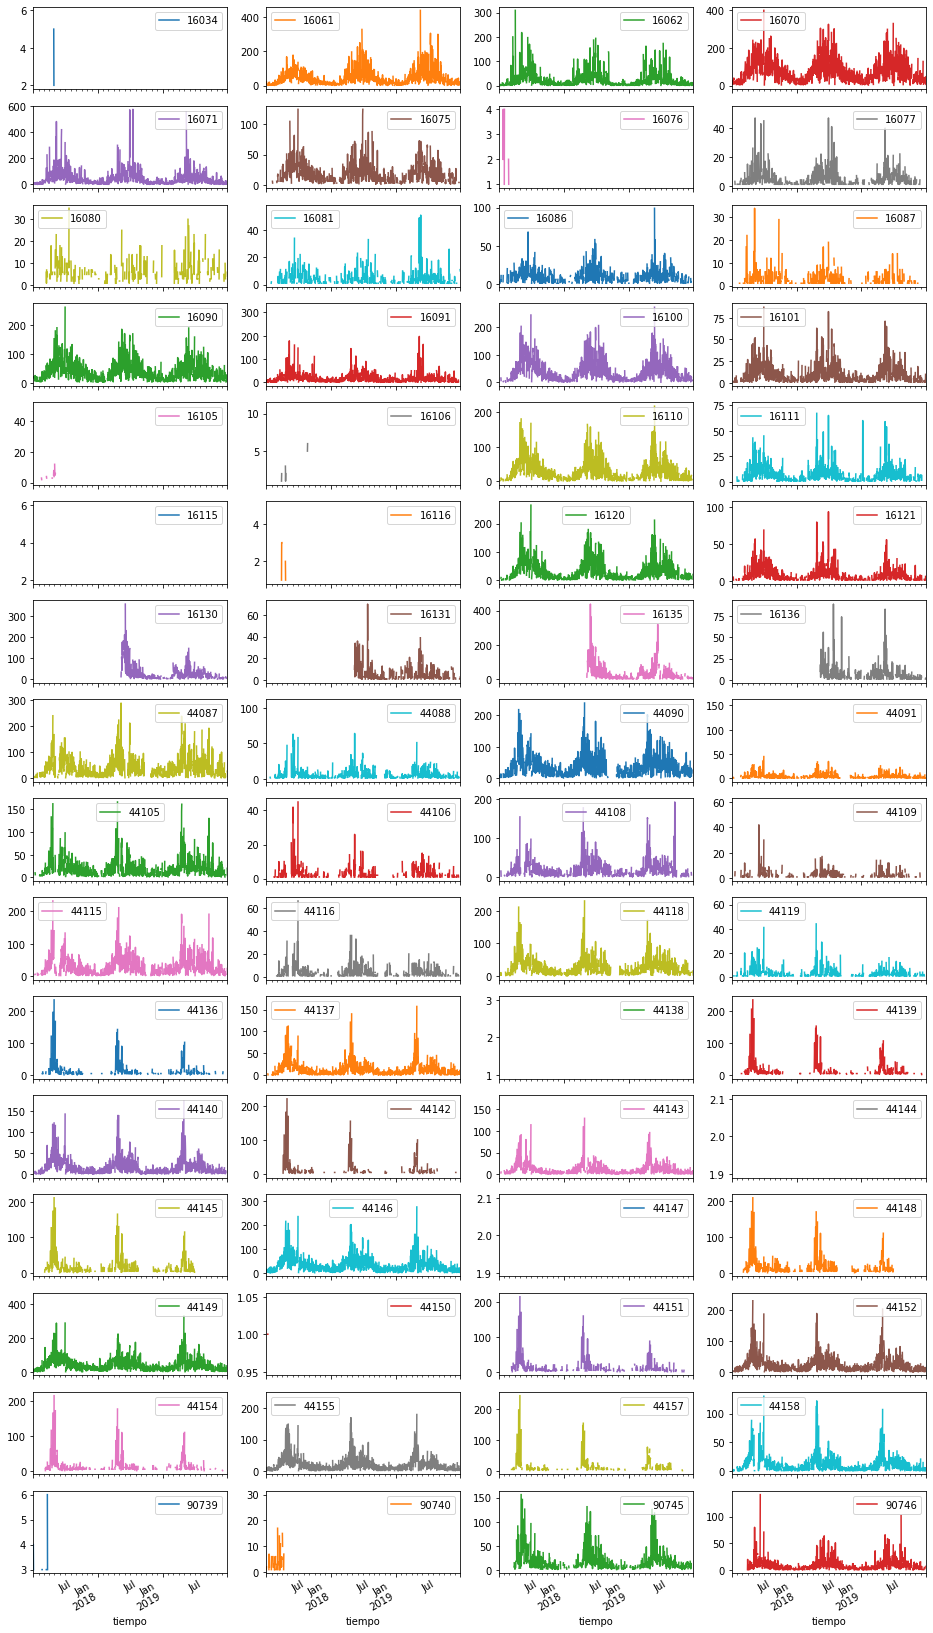

In [17]:
plot_grid(u_producto, n_cols=4, figsize=(16,32))

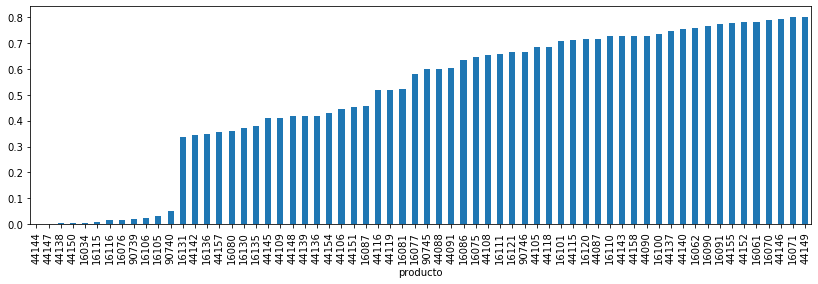

In [18]:
amount_info = get_amount_info(u_producto)
amount_info.sort_values().plot(kind="bar")

In [19]:
u_producto_forecastable = get_forecastables(u_producto, T=0.5)

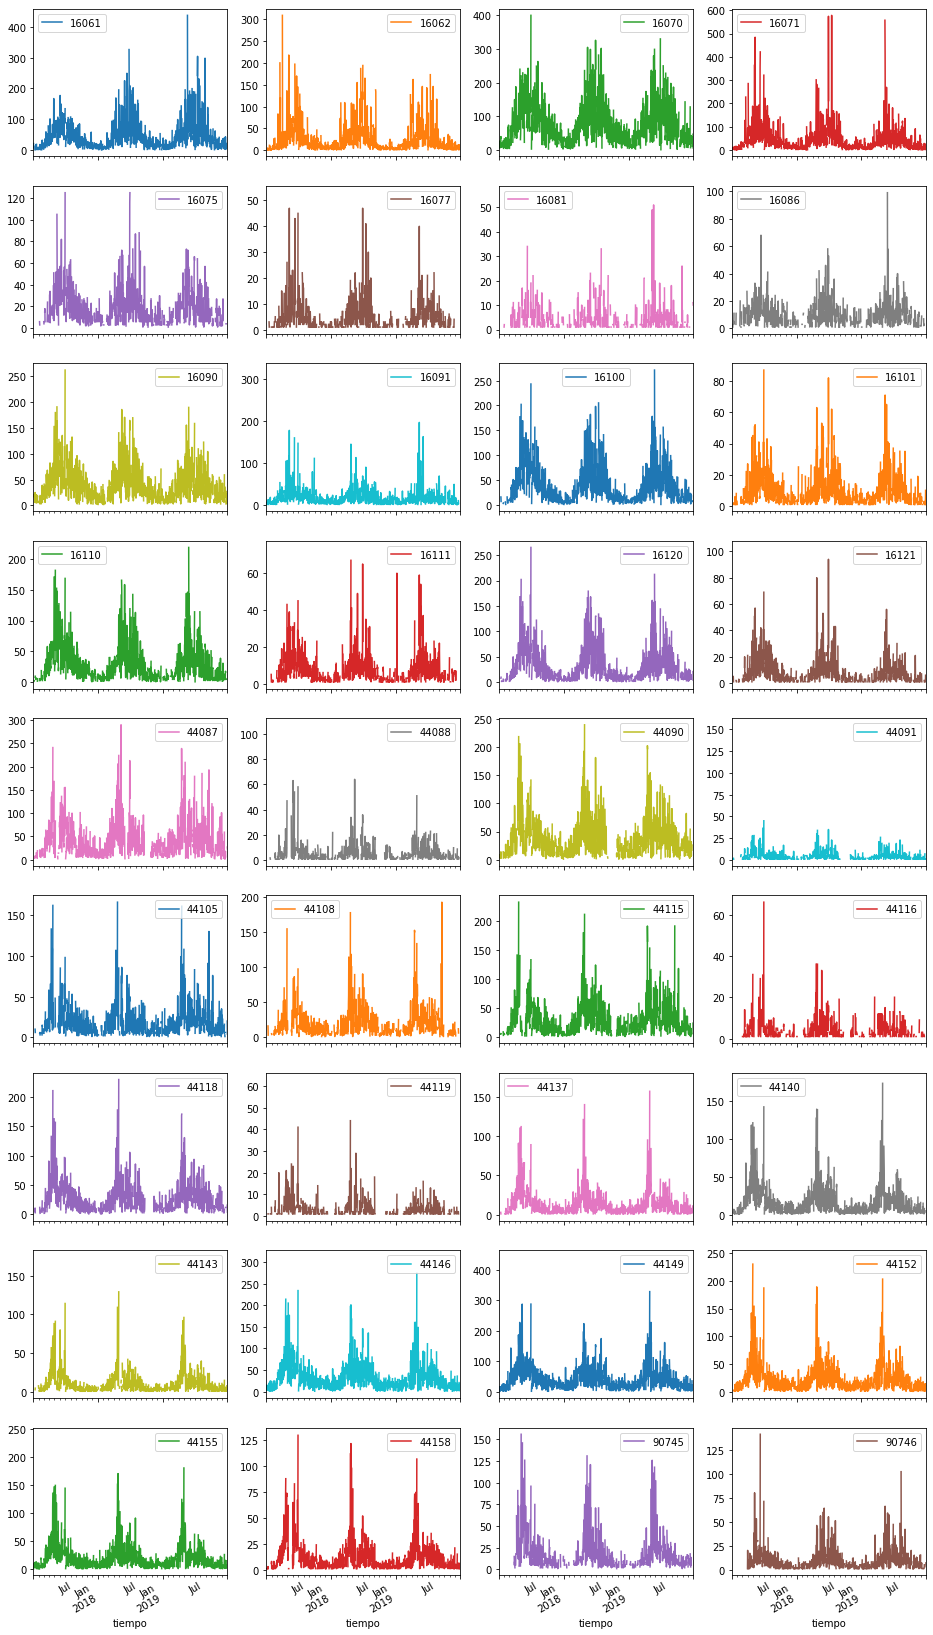

In [20]:
plot_grid(u_producto_forecastable, n_cols=4, figsize=(16, 32))

In [21]:
train, test = u_producto_forecastable[:"2018-12-31"], u_producto_forecastable["2019-01-01":]

In [26]:
import pmdarima as pm
import scipy
import matplotlib.pyplot as plt

In [179]:
def fourier_coeff(length, seasonalities, n_terms=10):
    x = np.arange(0, length)
    coeff_list = []
    for M in seasonalities:
        coeff_M_sin = np.zeros((length, K))
        coeff_M_cos = np.zeros((length, K))
        for k in range(n_terms):
            coeff_M_sin[:, k] = np.sin(2*np.pi*(k+1)*x/M)
            coeff_M_cos[:, k] = np.cos(2*np.pi*(k+1)*x/M)
        coeff_M = np.concatenate([coeff_M_sin, coeff_M_cos], axis=1)
        coeff_list.append(coeff_M)
    coeff = np.concatenate(coeff_list, axis=1)
    return coeff

In [180]:
item_id = 44149

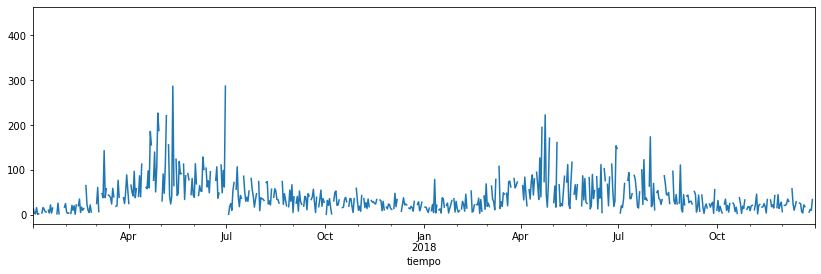

In [181]:
train[item_id].plot()

In [137]:
fcoeff = fourier_coeff(len(train[item_id]), seasonalities=[365], n_terms=10)

In [138]:
fcoeff.shape

(729, 20)

In [139]:
train[item_id]

tiempo
2017-01-02    14.0
2017-01-03     3.0
2017-01-04     2.0
2017-01-05    16.0
2017-01-06     1.0
              ... 
2018-12-27    12.0
2018-12-28    10.0
2018-12-29    34.0
2018-12-30     NaN
2018-12-31     NaN
Freq: D, Name: 44149, Length: 729, dtype: float64

In [182]:
idx = train.index

In [183]:
target, lmbda = boxcox(train[item_id].interpolate())

In [184]:
target = pd.Series(target, index=idx)

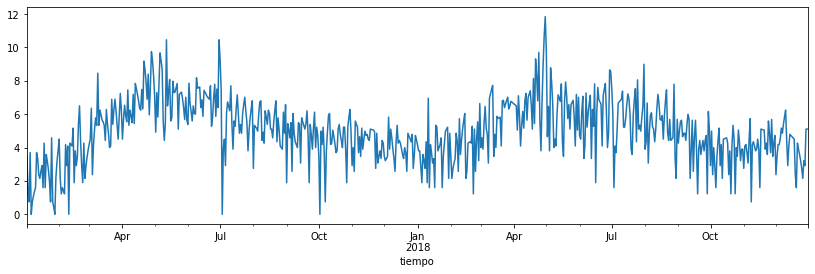

In [185]:
target.plot()

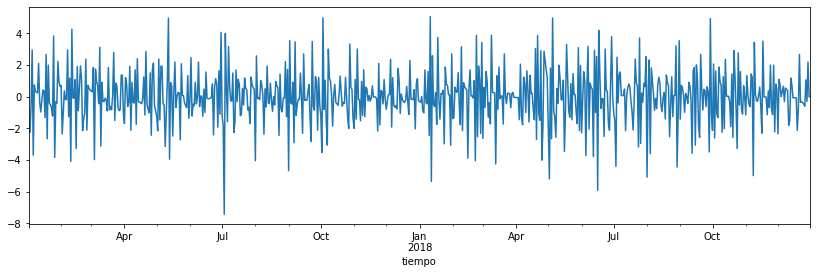

In [148]:
target.diff().plot()

In [186]:
model_arima = pm.auto_arima(
    target, 
    exogenous=fourier_coeff(len(target), [365], n_terms=5), 
    seasonal=False, 
    suppress_warnings=True)

In [187]:
pred = model_arima.predict(
    n_periods=365, 
    exogenous=fourier_coeff(365, [365], n_terms=5))

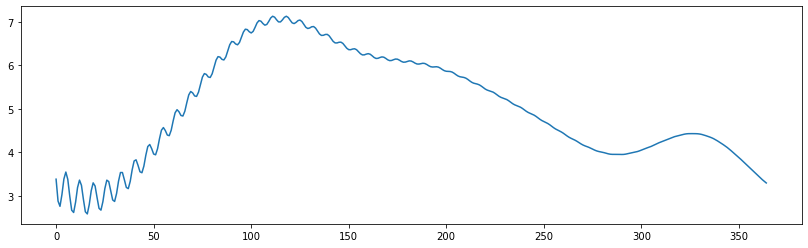

In [188]:
plt.plot(pred)

In [176]:
pred = inv_boxcox(pred, lmbda)

In [177]:
fcst = pd.Series(pred, index=test[item_id].index)

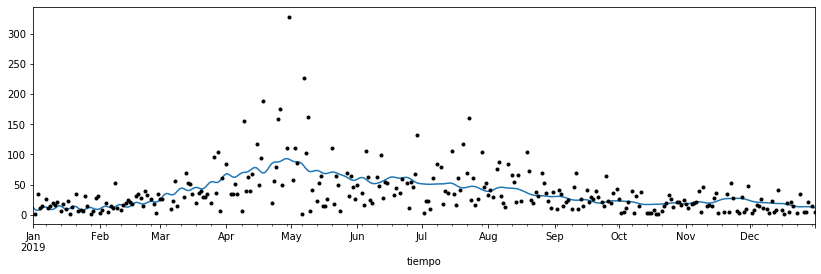

In [178]:
fcst.plot()
test[item_id].plot(style="k.")

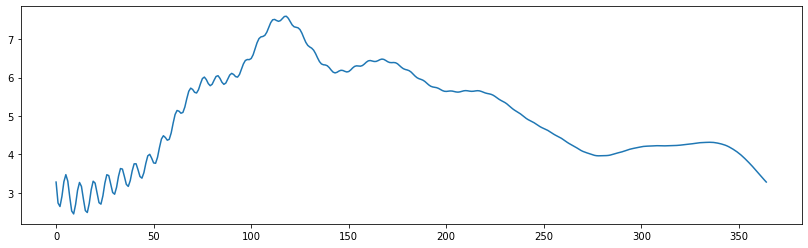

In [155]:
plt.plot(pred)

In [156]:
len(test)

365

In [38]:
x = np.arange(0, 3*365)
K = 10
M = 365
coeff_sin = np.zeros((len(x), K))
coeff_cos = np.zeros((len(x), K))
for k in range(K):
    coeff_sin[:, k] = np.sin(2*np.pi*(k+1)*x/M)
    coeff_cos[:, k] = np.cos(2*np.pi*(k+1)*x/M)
np.concatenate((coeff_sin, coeff_cos), axis=1)

In [52]:
x = np.arange(0, 3*365)
K = 10
M = 365
coeff = np.zeros((len(x), K), dtype="complex")
for k in range(K):
    coeff[:, k] = np.exp(1j*2*np.pi*(k+1)*x/M)


In [48]:
np.concatenate((coeff_sin, coeff_cos), axis=1)

(1095, 20)

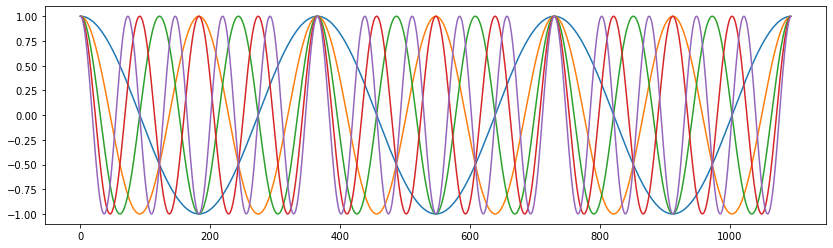

In [54]:
for k in range(5):
    plt.plot(x, coeff[:,k].real)

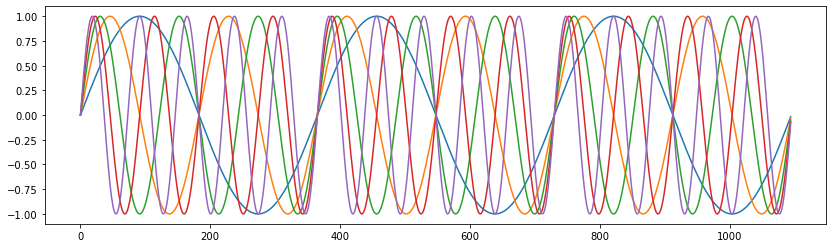

In [45]:
for k in range(5):
    plt.plot(x, coeff_sin[:,k])

In [36]:
x.shape

(1095,)

In [33]:
np.zeros((365*2, 10))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

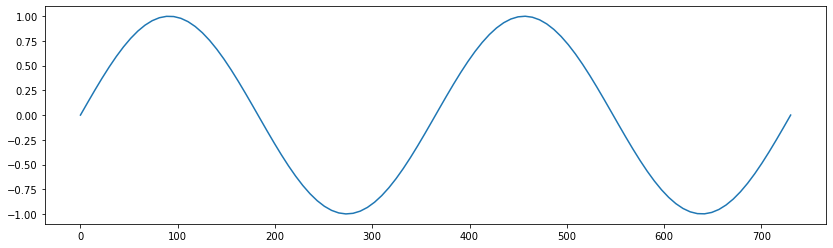

In [29]:
plt.plot(x, y)

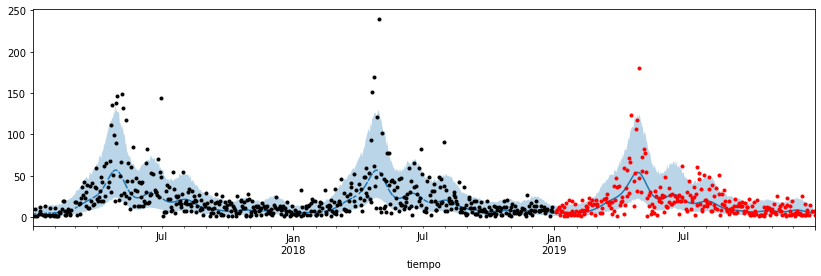

In [20]:
item = 44155
plot_fcst(fcst[item], train[item], test[item])

# Forecast por producto y región

In [21]:
u_producto_region = pd.pivot_table(
    data, 
    values="u pedidas", 
    index="tiempo", 
    columns=["producto", "sucursal"], 
    aggfunc="sum").asfreq("D")

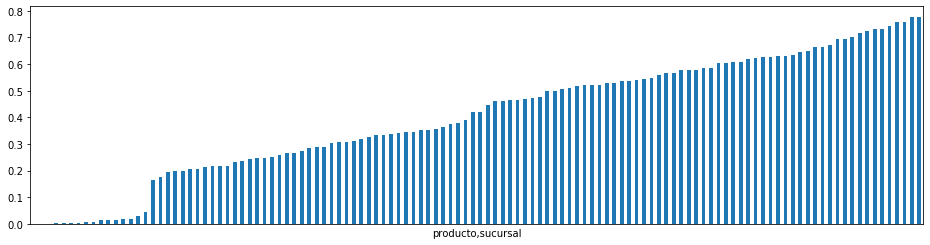

In [35]:
get_amount_info(u_producto_region).sort_values().plot(kind="bar", figsize=(16,4))
plt.xticks(ticks=[]);

In [24]:
u_producto_region_forecastable = get_forecastables(u_producto_region, T=0.3)

In [25]:
train, test = u_producto_region_forecastable[:"2018-12-31"], u_producto_region_forecastable["2019-01-01":]

In [26]:
model = ProphetForecaster(
    yearly_seasonality=10,
    weekly_seasonality=False, 
    daily_seasonality=False,)
model.fit(train)
fcst = model.predict(steps=365).asfreq("D")

Fitting...


80 of 80|#################################################################|100%


Forecasting...


80 of 80|#################################################################|100%


In [27]:
fcst

16061                                                       \
              neuquen                        santa fe                        
           yhat_lower      yhat yhat_upper yhat_lower      yhat yhat_upper   
ds                                                                           
2017-01-02        NaN       NaN        NaN   1.621817  5.386577  15.683748   
2017-01-03        NaN       NaN        NaN   1.390607  5.406648  16.699142   
2017-01-04        NaN       NaN        NaN        NaN       NaN        NaN   
2017-01-05        NaN       NaN        NaN   1.436094  5.440789  16.682178   
2017-01-06        NaN       NaN        NaN        NaN       NaN        NaN   
...               ...       ...        ...        ...       ...        ...   
2019-12-25   1.382195  5.541953  16.047625   1.832049  6.397680  18.138644   
2019-12-26   1.020122  5.396920  14.849836   1.794442  6.348595  19.675285   
2019-12-27   1.019241  5.265696  14.964361   1.879872  6.314513  20.094280   
2019-12-28   1.000660  5.148950  14.903477   1.931588  6.294069  18.708877   
2019-12-29   1.107906  5.046966  14.344457   1.911706  6.285694  18.135725   

                16062                                  ...      90745  \
              neuquen                        santa fe  ...    neuquen   
           yhat_lower      yhat yhat_upper yhat_lower  ... yhat_upper   
ds                                                     ...              
2017-01-02        NaN       NaN        NaN   0.723761  ...        NaN   
2017-01-03        NaN       NaN        NaN        NaN  ...        NaN   
2017-01-04        NaN       NaN        NaN        NaN  ...        NaN   
2017-01-05        NaN       NaN        NaN        NaN  ...        NaN   
2017-01-06        NaN       NaN        NaN   0.761337  ...        NaN   
...               ...       ...        ...        ...  ...        ...   
2019-12-25   0.611027  1.860933   6.497507   0.689933  ...  15.139345   
2019-12-26   0.643769  1.958496   6.656144   0.759867  ...  14.110996   
2019-12-27   0.672071  2.068379   8.672655   0.762676  ...  13.449616   
2019-12-28   0.753807  2.190337   8.690868   0.754653  ...  13.513202   
2019-12-29   0.806587  2.323737  10.669851        NaN  ...  12.481264   

                                                90746                       \
             santa fe                         neuquen                        
           yhat_lower      yhat yhat_upper yhat_lower      yhat yhat_upper   
ds                                                                           
2017-01-02        NaN       NaN        NaN        NaN       NaN        NaN   
2017-01-03        NaN       NaN        NaN        NaN       NaN        NaN   
2017-01-04        NaN       NaN        NaN        NaN       NaN        NaN   
2017-01-05        NaN       NaN        NaN        NaN       NaN        NaN   
2017-01-06        NaN       NaN        NaN        NaN       NaN        NaN   
...               ...       ...        ...        ...       ...        ...   
2019-12-25   2.322525  5.172407  11.232223   0.660931  1.510417   4.264204   
2019-12-26   2.338193  5.172024  12.244235   0.655615  1.507262   4.518459   
2019-12-27   2.336391  5.152467  12.858118   0.663800  1.505460   4.824693   
2019-12-28   2.401454  5.115178  12.898156   0.670316  1.504914   4.445017   
2019-12-29   2.258034  5.062273  12.017469   0.650984  1.505549   4.428513   

                                            
             santa fe                       
           yhat_lower      yhat yhat_upper  
ds                                          
2017-01-02        NaN       NaN        NaN  
2017-01-03        NaN       NaN        NaN  
2017-01-04        NaN       NaN        NaN  
2017-01-05        NaN       NaN        NaN  
2017-01-06        NaN       NaN        NaN  
...               ...       ...        ...  
2019-12-25   0.781537  1.730692   4.737335  
2019-12-26   0.727671  1.757224   4.493655  
2019-12-27   0.723934  1.783074   4.66

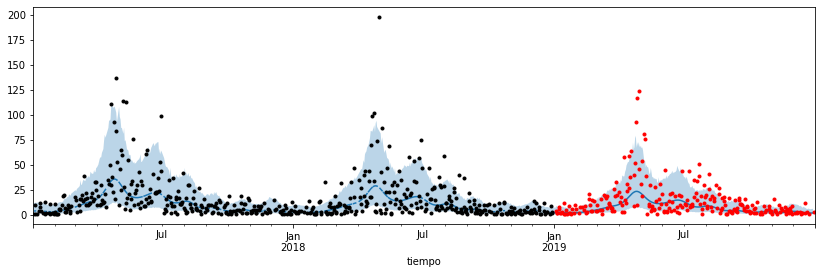

In [29]:
item = (44155, "santa fe")
plot_fcst(fcst[item], train[item], test[item])